Pgeocode:https://pythonlang.dev/repo/symerio-pgeocode/ 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
import pandas as pd
import datetime
import time
import os
import geopy.distance
from math import dist
import sklearn.neighbors

## Useful functions

In [2]:
def list_slicer (l:list,c1:int,c2:int):
    # slice a non-numpy 2d list from column 1 (c1) to column 2 (c2)
    # return a 2d sublist
    result = []
    for row in l:
        result.append(row[c1:c2])
    return result


In [3]:

def getDateRangeFromWeek(p_year,p_week):
    '''
    # get week start & end date
    # in YYYYMMDD format
    '''
    start = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    f = start + datetime.timedelta(days=1) # otherwise first day of wk1 is last day of Dec
    l = f + datetime.timedelta(days=6.9)
    firstday = 10000*f.year+100*f.month + f.day
    lastday = 10000*l.year+100*l.month + l.day
    return firstday, lastday

#Call function to get dates range 
firstdate, lastdate =  getDateRangeFromWeek('2013','1')
print('print function ',firstdate,' ', lastdate)


print function  20130101   20130107


## Station query

In [4]:
# convert station list to array
# there should be better ways but I didn't find any...
rows, cols = (119503, 9)
Stations= [[0 for i in range(cols)] for j in range(rows)]
with open('ghcnd-stations.txt','r') as f:
    s = f.readlines()
i = 0
for station in s:
    Stations[i][0]=station[:11] #ID
    Stations[i][1]=float(station[12:20]) # Latitude
    Stations[i][2]=float(station[21:30]) # Lontitude
    Stations[i][3]=float(station[31:37]) # Elevatioin
    Stations[i][4]=station[38:40].strip() # state
    Stations[i][5]=station[41:71].strip() # name
    Stations[i][6]=station[72:75].strip() # GSN flag
    Stations[i][7]=station[76:79].strip() # HCN/CRN flag
    WMO = station[80:85].strip()
    if len(WMO)>0:
        Stations[i][8]=int(WMO) # WMO ID
    else:
        Stations[i][8]=""
    i +=1


In [5]:
# Station_df as the station dataframe

cols = ["stationID","Latitude","Longtitude","Elevation","State","Name","GSN","HCN/CRN","WMO"]
Station_df = pd.DataFrame (Stations, columns = cols)
Station_df.set_index('stationID')
#Station_df.style.set_properties(subset="Name",**{'text-align': 'left'})
Station_df.head()

,stationID,Latitude,Longtitude,Elevation,State,Name,GSN,HCN/CRN,WMO
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217


In [6]:
# find all Stations in a state
StateName = "AL"
selected_stations=Station_df.query('State==@StateName')
selected_stations

,stationID,Latitude,Longtitude,Elevation,State,Name,GSN,HCN/CRN,WMO
54077,US1ALAT0002,32.4756,-86.4393,106.1,AL,PRATTVILLE 1.1 NNE,,,
54078,US1ALAT0010,32.4262,-86.5390,95.1,AL,PRATTVILLE 5.9 WSW,,,
54079,US1ALAT0013,32.6444,-86.4302,268.2,AL,DEATSVILLE 3.4 NW,,,
54080,US1ALAT0014,32.4825,-86.4854,100.3,AL,PRATTVILLE 2.7 WNW,,,
54081,US1ALBB0003,33.0212,-86.9208,141.1,AL,WILTON 4.8 SSW,,,
...,...,...,...,...,...,...,...,...,...
118334,USW00073802,31.9156,-86.3114,187.1,AL,HIGHLAND HOME 2 S,,,
118335,USW00073803,33.5722,-86.0572,160.0,AL,TALLADEGA 10 NNE,,,
118464,USW00093806,33.2119,-87.6161,45.7,AL,TUSCALOOSA MUNI AP,,HCN,
118481,USW00093826,30.4000,-87.6000,21.9,AL,BARIN FLD NAAS,,,


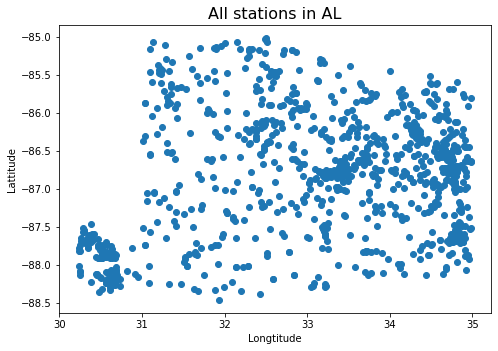

In [7]:
# plot selected stations with coordinates

Lat = selected_stations["Latitude"].to_numpy()
Long = selected_stations["Longtitude"].to_numpy()
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(Lat,Long)
ax.set_ylabel("Lattitude")
ax.set_xlabel("Longtitude")
ax.set_title('All stations in ' +str(StateName), fontsize=16)
plt.show()


In [8]:
# calculate distance between stations

Stations_A = selected_stations.iloc[:,:3]
Stations_B = Stations_A.copy()
Stations_B = Stations_B.rename(columns={"stationID": "stationID_B","Latitude": "Latitude_B","Longtitude": "Longtitude_B"})
#df.rename(columns={"A": "a", "B": "c"})
Stations_A, Stations_B

(          stationID  Latitude  Longtitude
 54077   US1ALAT0002   32.4756    -86.4393
 54078   US1ALAT0010   32.4262    -86.5390
 54079   US1ALAT0013   32.6444    -86.4302
 54080   US1ALAT0014   32.4825    -86.4854
 54081   US1ALBB0003   33.0212    -86.9208
 ...             ...       ...         ...
 118334  USW00073802   31.9156    -86.3114
 118335  USW00073803   33.5722    -86.0572
 118464  USW00093806   33.2119    -87.6161
 118481  USW00093826   30.4000    -87.6000
 118497  USW00093843   31.2333    -85.4333
 
 [1025 rows x 3 columns],
         stationID_B  Latitude_B  Longtitude_B
 54077   US1ALAT0002     32.4756      -86.4393
 54078   US1ALAT0010     32.4262      -86.5390
 54079   US1ALAT0013     32.6444      -86.4302
 54080   US1ALAT0014     32.4825      -86.4854
 54081   US1ALBB0003     33.0212      -86.9208
 ...             ...         ...           ...
 118334  USW00073802     31.9156      -86.3114
 118335  USW00073803     33.5722      -86.0572
 118464  USW00093806     33.2119 

In [9]:
# add columns with radians for latitude and longitude
Stations_A[['lat_radians_A','long_radians_A']] = (
    np.radians(Stations_A.loc[:,['Latitude','Longtitude']])
)
Stations_B[['lat_radians_B','long_radians_B']] = (
    np.radians(Stations_B.loc[:,['Latitude_B','Longtitude_B']])
)


In [10]:
Stations_A, Stations_B

(          stationID  Latitude  Longtitude  lat_radians_A  long_radians_A
 54077   US1ALAT0002   32.4756    -86.4393       0.566806       -1.508650
 54078   US1ALAT0010   32.4262    -86.5390       0.565944       -1.510390
 54079   US1ALAT0013   32.6444    -86.4302       0.569752       -1.508492
 54080   US1ALAT0014   32.4825    -86.4854       0.566927       -1.509455
 54081   US1ALBB0003   33.0212    -86.9208       0.576329       -1.517054
 ...             ...       ...         ...            ...             ...
 118334  USW00073802   31.9156    -86.3114       0.557032       -1.506418
 118335  USW00073803   33.5722    -86.0572       0.585945       -1.501981
 118464  USW00093806   33.2119    -87.6161       0.579657       -1.529189
 118481  USW00093826   30.4000    -87.6000       0.530580       -1.528908
 118497  USW00093843   31.2333    -85.4333       0.545124       -1.491092
 
 [1025 rows x 5 columns],
         stationID_B  Latitude_B  Longtitude_B  lat_radians_B  long_radians_B
 54077

In [11]:
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
    (Stations_B[['lat_radians_B','long_radians_B']],
     Stations_A[['lat_radians_A','long_radians_A']])*3959
)
# Note that 3959 is the radius of the earth in miles
df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=Stations_B['stationID_B'], 
                 columns=Stations_A['stationID'])
)



C:\Users\cheng\miniconda3\envs\FarmLandMetrics\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [12]:
df_dist_matrix

stationID,US1ALAT0002,US1ALAT0010,US1ALAT0013,US1ALAT0014,US1ALBB0003,US1ALBB0004,US1ALBB0005,US1ALBB0006,US1ALBB0008,US1ALBL0002,...,USW00063895,USW00063896,USW00063897,USW00063899,USW00073801,USW00073802,USW00073803,USW00093806,USW00093826,USW00093843
stationID_B,,,,,,,,,,,,,,,,,,,,,
US1ALAT0002,0.000000,6.741372,11.675706,2.729132,46.949510,46.992262,64.238967,46.605456,51.722168,102.429219,...,155.069091,155.373740,32.927256,98.722593,84.057565,39.410724,78.939591,85.178256,158.903519,104.183758
US1ALAT0010,6.741372,0.000000,16.355076,4.990035,46.721132,46.733770,63.368117,46.703075,50.253782,105.664407,...,155.514658,159.759298,26.414895,93.508834,81.769974,37.709042,83.963663,82.820304,153.347032,104.915779
US1ALAT0013,11.675706,16.355076,0.000000,11.639597,38.590240,38.671705,56.330979,37.833577,44.978302,90.824592,...,145.123770,143.783018,38.453080,109.832496,77.950512,50.834281,67.646019,79.171058,169.696443,113.681932
US1ALAT0014,2.729132,4.990035,11.639597,0.000000,45.008135,45.042243,62.145442,44.760515,49.463272,101.829992,...,153.407029,155.358574,30.522824,98.217259,81.646978,40.471051,79.276445,82.754086,158.185064,106.126500
US1ALBB0003,46.949510,46.721132,38.590240,45.008135,0.000000,0.211241,17.785686,2.267789,9.971111,68.106891,...,108.875567,127.107718,47.533781,129.867157,40.998989,84.250212,62.746853,42.341836,185.465202,151.119577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USW00073802,39.410724,37.709042,50.834281,40.471051,84.250212,84.250254,100.359960,84.340602,86.834002,141.588555,...,193.122251,192.836134,48.622610,68.819849,116.559520,0.000000,115.416336,117.453025,129.506988,69.962100
USW00073803,78.939591,83.963663,67.646019,79.276445,62.746853,62.953160,69.516204,60.522072,71.954441,38.506062,...,112.575808,77.597206,100.806239,177.471574,91.931991,115.416336,0.000000,93.315997,237.098592,165.659116
USW00093806,85.178256,82.820304,79.171058,82.754086,42.341836,42.188822,26.181934,43.976274,34.256614,80.302405,...,85.968648,138.103150,71.014667,146.581737,1.428517,117.453025,93.315997,0.000000,194.297799,186.997674


In [13]:
# Unpivot this dataframe from wide format to long format.
# When you unpivot, the data in the pivot table becomes a
# column named 'value'. Rename this column to 'miles' for clarity.
df_dist_long = (
    pd.melt(df_dist_matrix.reset_index(),id_vars='stationID_B')
)
df_dist_long = df_dist_long.rename(columns={'value':'miles'})
df_dist_long = df_dist_long[['stationID','stationID_B',"miles"]]
df_dist_long2 = df_dist_long.set_index(['stationID', 'stationID_B'])
df_dist_long2

miles
stationID   stationID_B            
US1ALAT0002 US1ALAT0002    0.000000
            US1ALAT0010    6.741372
            US1ALAT0013   11.675706
            US1ALAT0014    2.729132
            US1ALBB0003   46.949510
...                             ...
USW00093843 USW00073802   69.962100
            USW00073803  165.659116
            USW00093806  186.997674
            USW00093826  140.875703
            USW00093843    0.000000

[1050625 rows x 1 columns]

## Process .csv files in /by_year folder

In [14]:
# open a station file
import os
year = 2014
filename = os.path.join("by_year", str(year) + ".csv")
colnames = ['ID','date','elem','value','M-flag','Q-flag','S-Flag','ObsTime']
df = pd.read_csv(filename,names=colnames, header=None)
# df['Date'] = pd.to_datetime(df['YYYYMMDD'].astype(str), format='%Y%m%d')
#display(df.loc[50:60])
df

,ID,date,elem,value,M-flag,Q-flag,S-Flag,ObsTime
0,AE000041196,20140101,TMAX,244,NaN,NaN,S,NaN
1,AE000041196,20140101,TMIN,128,NaN,NaN,S,NaN
2,AE000041196,20140101,TAVG,182,H,NaN,S,NaN
3,AEM00041194,20140101,TMAX,241,NaN,NaN,S,NaN
4,AEM00041194,20140101,TMIN,159,NaN,NaN,S,NaN
...,...,...,...,...,...,...,...,...
34767495,ZI000067975,20141231,PRCP,30,NaN,NaN,S,NaN
34767496,ZI000067975,20141231,TAVG,214,H,NaN,S,NaN
34767497,ZI000067983,20141231,TMIN,180,NaN,NaN,S,NaN
34767498,ZI000067983,20141231,PRCP,140,NaN,NaN,S,NaN


In [15]:
df2 = df.iloc[:,:4] # remove the flags and obstimes
df2

,ID,date,elem,value
0,AE000041196,20140101,TMAX,244
1,AE000041196,20140101,TMIN,128
2,AE000041196,20140101,TAVG,182
3,AEM00041194,20140101,TMAX,241
4,AEM00041194,20140101,TMIN,159
...,...,...,...,...
34767495,ZI000067975,20141231,PRCP,30
34767496,ZI000067975,20141231,TAVG,214
34767497,ZI000067983,20141231,TMIN,180
34767498,ZI000067983,20141231,PRCP,140


In [16]:
df2 = df2[["ID","elem","date","value"]] # Reduce comlumns
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d') # convert date format
df2

,ID,elem,date,value
0,AE000041196,TMAX,2014-01-01,244
1,AE000041196,TMIN,2014-01-01,128
2,AE000041196,TAVG,2014-01-01,182
3,AEM00041194,TMAX,2014-01-01,241
4,AEM00041194,TMIN,2014-01-01,159
...,...,...,...,...
34767495,ZI000067975,PRCP,2014-12-31,30
34767496,ZI000067975,TAVG,2014-12-31,214
34767497,ZI000067983,TMIN,2014-12-31,180
34767498,ZI000067983,PRCP,2014-12-31,140


In [17]:
df2['day_of_year'] = df2['date'].dt.dayofyear
df2

,ID,elem,date,value,day_of_year
0,AE000041196,TMAX,2014-01-01,244,1
1,AE000041196,TMIN,2014-01-01,128,1
2,AE000041196,TAVG,2014-01-01,182,1
3,AEM00041194,TMAX,2014-01-01,241,1
4,AEM00041194,TMIN,2014-01-01,159,1
...,...,...,...,...,...
34767495,ZI000067975,PRCP,2014-12-31,30,365
34767496,ZI000067975,TAVG,2014-12-31,214,365
34767497,ZI000067983,TMIN,2014-12-31,180,365
34767498,ZI000067983,PRCP,2014-12-31,140,365


In [18]:
df2['wkk'] = (df2['day_of_year']//7)+1
df2

,ID,elem,date,value,day_of_year,wkk
0,AE000041196,TMAX,2014-01-01,244,1,1
1,AE000041196,TMIN,2014-01-01,128,1,1
2,AE000041196,TAVG,2014-01-01,182,1,1
3,AEM00041194,TMAX,2014-01-01,241,1,1
4,AEM00041194,TMIN,2014-01-01,159,1,1
...,...,...,...,...,...,...
34767495,ZI000067975,PRCP,2014-12-31,30,365,53
34767496,ZI000067975,TAVG,2014-12-31,214,365,53
34767497,ZI000067983,TMIN,2014-12-31,180,365,53
34767498,ZI000067983,PRCP,2014-12-31,140,365,53


In [19]:
df2 = df2[["ID","elem","wkk","value"]]
df2

,ID,elem,wkk,value
0,AE000041196,TMAX,1,244
1,AE000041196,TMIN,1,128
2,AE000041196,TAVG,1,182
3,AEM00041194,TMAX,1,241
4,AEM00041194,TMIN,1,159
...,...,...,...,...
34767495,ZI000067975,PRCP,53,30
34767496,ZI000067975,TAVG,53,214
34767497,ZI000067983,TMIN,53,180
34767498,ZI000067983,PRCP,53,140


In [20]:
# weekly data for all stations

df3=df2.groupby(["ID","elem","wkk"]).agg({"value":['sum']})
#df3=df2.groupby(["ID","elem","wkk"])['value'].sum()
df3

value
                       sum
ID          elem wkk      
AE000041196 PRCP 1       0
                 2      26
                 3       0
                 4      28
                 5      10
...                    ...
ZI000067983 TMIN 49    918
                 50    677
                 51    387
                 52   1357
                 53    365

[5915282 rows x 1 columns]

In [21]:
# Check data in a specific station
StationID = "US1ALBL0002"
Station_info =Station_df.query('stationID==@StationID')
print(Station_info) 

         stationID  Latitude  Longtitude  Elevation State         Name GSN  \
54086  US1ALBL0002   33.9554    -86.5439      171.9    AL  ROSA 2.8 SW       

      HCN/CRN WMO  
54086              


In [22]:
# precipitation in one station

state = (Station_info["State"]).values[0]
Element = "PRCP"
df4 = df3.query('ID == @StationID & elem=="PRCP"')
print("weekly "+ Element + " at station " + StationID + " in "+ str(year) +" in " + state)
df4

weekly PRCP at station US1ALBL0002 in 2014 in AL


value
                       sum
ID          elem wkk      
US1ALBL0002 PRCP 1     181
                 2     335
                 3     137
                 4       0
                 5     584
                 6     173
                 7     399
                 8     797
                 9     201
                 10     61
                 11    435
                 12     58
                 13    277
                 14    950
                 15      0
                 16    356
                 17    264
                 18   1257
                 19     10
                 20    501
                 21      0
                 22    104
                 23    353
                 24    738
                 25     13
                 26    572
                 27      0
                 28    132
                 29    258
                 30      0
                 31      0
                 32    444
                 33      5
                 34    147
                 35     94
                 36    134
                 37    162
                 38     28
                 39      0
                 40    208
                 41    125
                 42    902
                 43      0
                 44    152
                 45     51
                 46    643
                 47    191
                 48      3
                 49    826
                 50      0
                 51     63
                 52   1373
                 53     13

In [23]:
# plot weekly sum in one station
df4x = df4.reset_index()
df4x.head()

,ID,elem,wkk,value
,,,,sum
0,US1ALBL0002,PRCP,1,181
1,US1ALBL0002,PRCP,2,335
2,US1ALBL0002,PRCP,3,137
3,US1ALBL0002,PRCP,4,0
4,US1ALBL0002,PRCP,5,584


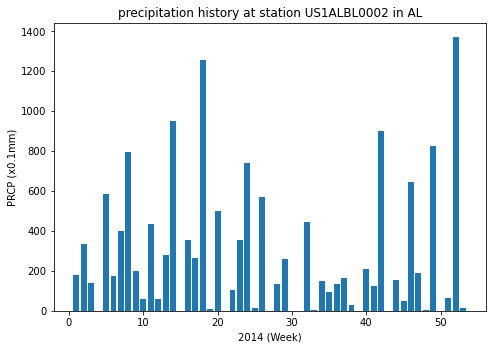

In [24]:
# plot weekly sum in one station
x = df4x["wkk"].to_numpy()
y = ((df4x["value"]).to_numpy()).flatten()
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_ylabel(Element+" (x0.1mm)")
ax.set_xlabel(str(year) + " (Week)")
ax.set_title('precipitation history at station '+str(StationID)+' in '+str(state))
plt.show()

### Yearly prcp in all stations in AL

In [43]:
# get yearly precipitation for all station in AL
#df3=df2.groupby(["ID","elem","wkk"]).agg({"value":['sum']})
stationList = selected_stations["stationID"].to_list()
selected_stations = df3.query('ID==@stationList')
#selected_stations_yr = selected_stations.groupby(["ID","elem","wkk"]).agg({"value":['sum']})
#selected_stations_yr
# df3=df2.groupby(["ID","elem","wkk"]).agg({"value":['sum']})

selected_stations

KeyError: 'stationID'

In [ ]:
selected_stations_yr = selected_stations.groupby(["ID","elem","wkk"]).agg({"value":['sum']})

## Process .dly file in /all folder
These are text files which is named by stationID and each file has all daily data from that station

In [25]:
# open a station file
# StationID entered in previous section
# state: state name aquired in previous section
# Element = "PRCP" Entered in previous section

filename = os.path.join("all", StationID +".dly")
print(filename)
with open(filename,'r') as f:
    records = f.readlines()

all\US1ALBL0002.dly


In [26]:
#convert the station file into an array
# globals()[stationID] convert the statonID to the variable 
# so that if stationID = "AL123", AL123 now becomes the variable
# i.e., the list name is "AL123", instead of "stationID"

l=(len(records))
rows,cols = (l,35)
i = 0
data_s01= [[0 for i in range(cols)] for j in range(rows)]
for r in records:
    data_s01[i][0]= r[0:11].strip() #ID
    data_s01[i][1]= int(r[11:15].strip()) #year
    data_s01[i][2]= int(r[15:17].strip()) #month
    data_s01[i][3]= r[17:21].strip() #element PRCP (tenths of mm); SNOW(mm); SNWD = Snow depth (mm)
                               # TMAX = Maximum temperature (tenths of degrees C)
                               # TMIN = Minimum temperature (tenths of degrees C)
    data_s01[i][4]="" if len(r[21:26].strip())==0 else int(r[21:26].strip()) #V1
    data_s01[i][5]="" if len(r[29:34].strip())==0 else int(r[29:34].strip()) #V2
    data_s01[i][6]="" if len(r[37:42].strip())==0 else int(r[37:42].strip()) #V3
    data_s01[i][7]="" if len(r[45:50].strip())==0 else int(r[45:50].strip()) #V4
    data_s01[i][8]="" if len(r[53:58].strip())==0 else int(r[53:58].strip()) #V5
    data_s01[i][9]="" if len(r[61:66].strip())==0 else int(r[61:66].strip()) #V6
    data_s01[i][10]="" if len(r[69:74].strip())==0 else int(r[69:74].strip()) #V7
    data_s01[i][11]="" if len(r[77:82].strip())==0 else int(r[77:82].strip()) #V8
    data_s01[i][12]="" if len(r[85:90].strip())==0 else int(r[85:90].strip()) #V9
    data_s01[i][13]="" if len(r[93:98].strip())==0 else int(r[93:98].strip()) #V10
    data_s01[i][14]="" if len(r[101:106].strip())==0 else int(r[101:106].strip()) #V11
    data_s01[i][15]="" if len(r[109:114].strip())==0 else int(r[109:114].strip()) #V12
    data_s01[i][16]="" if len(r[117:122].strip())==0 else int(r[117:122].strip()) #V13
    data_s01[i][17]="" if len(r[125:130].strip())==0 else int(r[125:130].strip()) #V14
    data_s01[i][18]="" if len(r[133:138].strip())==0 else int(r[133:138].strip()) #V15
    data_s01[i][19]="" if len(r[141:146].strip())==0 else int(r[141:146].strip()) #V16
    data_s01[i][20]="" if len(r[149:154].strip())==0 else int(r[149:154].strip()) #V17
    data_s01[i][21]="" if len(r[157:162].strip())==0 else int(r[157:162].strip()) #V18
    data_s01[i][22]="" if len(r[165:170].strip())==0 else int(r[165:170].strip()) #V19
    data_s01[i][23]="" if len(r[173:178].strip())==0 else int(r[173:178].strip()) #V20
    data_s01[i][24]="" if len(r[181:186].strip())==0 else int(r[181:186].strip()) #V21
    data_s01[i][25]="" if len(r[189:194].strip())==0 else int(r[189:194].strip()) #V22
    data_s01[i][26]="" if len(r[197:202].strip())==0 else int(r[197:202].strip()) #V23
    data_s01[i][27]="" if len(r[205:210].strip())==0 else int(r[205:210].strip()) #V24
    data_s01[i][28]="" if len(r[213:218].strip())==0 else int(r[213:218].strip()) #V25
    data_s01[i][29]="" if len(r[221:226].strip())==0 else int(r[221:226].strip()) #V26
    data_s01[i][30]="" if len(r[229:234].strip())==0 else int(r[229:234].strip()) #V27
    data_s01[i][31]="" if len(r[237:242].strip())==0 else int(r[237:242].strip()) #V28
    data_s01[i][32]="" if len(r[245:250].strip())==0 else int(r[245:250].strip()) #V29
    data_s01[i][33]="" if len(r[253:258].strip())==0 else int(r[253:258].strip()) #V30
    data_s01[i][34]="" if len(r[261:266].strip())==0 else int(r[261:266].strip()) #V31

    i+=1

In [27]:
# Check year range included the file
years = []
for rows in (data_s01):
    if rows[1] not in years:
        years.append(rows[1])
years.sort()
print(years)

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


In [28]:
# find preciptation in a year
# known Problem: values are recalculated therefore incorrect if re-run this code block alone
#year  entered previously (by_year file)
#Element = "PRCP"

y_prcp = [] # whole year data
for row in data_s01:
    if row[1]==year:
        if row[3]==Element:
            row[4:]=[0 if i ==-9999 else round(i/10,1) for i in row[4:]] # replace -9999 with 0
            y_prcp.append(row[2:])


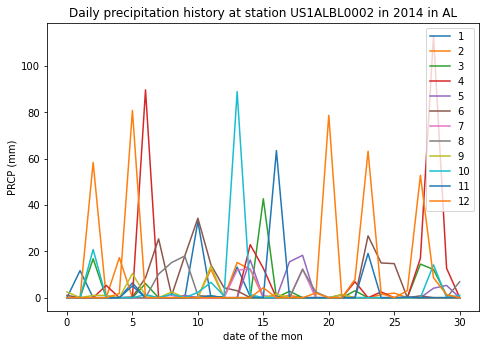

In [29]:
# plot daily prcp of each month
fig=plt.figure(1)
ax = fig.add_axes([0,0,1,1])
lg =[] # legend
for row in y_prcp:
    plt.plot(row[2:])
    lg.append(str(row[0]))
plt.legend(lg)
ax.set_ylabel(Element+" (mm)")
ax.set_xlabel("date of the mon")
ax.set_title('Daily precipitation history at station '+str(StationID)+' in '+str(year)+' in '+str(state))

m_prcp = [] # month total 
for row in y_prcp:
    m=(row[:2])
    m.append(round(sum(row[2:]),1))
    m_prcp.append(m)
#print(m_prcp)

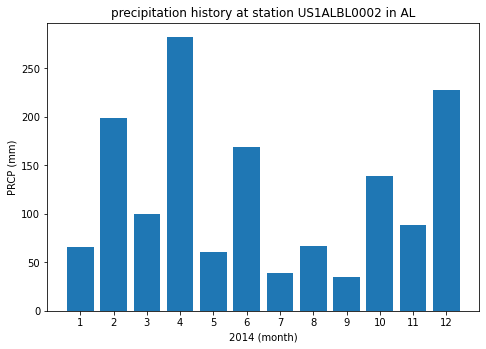

In [30]:


# plot monthly sum 
fig=plt.figure(2)
ax = fig.add_axes([0,0,1,1])
mon =[] # legend
msum =[]
for row in m_prcp:
    msum.append(row[2])
    mon.append(str(row[0]))
ax.bar(mon,msum)
ax.set_ylabel(Element+" (mm)")
ax.set_xlabel(str(year) + " (month)")
ax.set_title('precipitation history at station '+str(StationID)+' in '+str(state))
plt.show()


## Rainfall prediction

references:\
Using Weighted K-Means Clustering to Determine Distribution Centres Locations
https://towardsdatascience.com/using-weighted-k-means-clustering-to-determine-distribution-centres-locations-2567646fc31d

In [ ]:
stationList = selected_stations["stationID"].to_list()